In [2]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
init_printing(use_latex='mathjax')

In [3]:
phi = symbols('\phi', real=True) # nieprzesuniete
Lam = symbols('\lambda', real=True, positive=True, nonzero=True)
DT = symbols('\delta{t}', real=True, positive=True, nonzero=True)

tilde_phi= symbols('\\tilde{\phi}', real=True)
tilde_phi, DT

(\tilde{\phi}, \delta{t})

In [4]:
given = [tilde_phi]

unknown = [phi]

Q = [Lam*phi*(1-phi**2)]

M = Matrix

In [15]:
# EQs = Eq(M(given), M(unknown) - DT*M(Q)/2)  # it is assumed that DT=1 in LBM
EQs = Eq(M(given), M(unknown) - M(Q)/2)  
EQs

                 ⎡               ⎛        2⎞       ⎤
                 ⎢  \lambda⋅\phi⋅⎝1 - \phi ⎠       ⎥
[\tilde{\phi}] = ⎢- ──────────────────────── + \phi⎥
                 ⎣             2                   ⎦

In [16]:
solutions = solve(EQs, unknown, dict=True)
symbolic_solutions_as_matrix = Matrix([list(s.values()) for s in solutions])
symbolic_solutions_as_matrix

⎡                        _____________________________________________________
⎢                       ╱       _________________________________________     
⎢                      ╱       ╱                  2                    3      
⎢                     ╱       ╱  2916⋅\tilde{\phi}    108⋅(2 - \lambda)       
⎢                    ╱       ╱   ────────────────── + ──────────────────      
⎢                   ╱       ╱                2                    3           
⎢  ⎛  1   √3⋅ⅈ⎞    ╱      ╲╱          \lambda              \lambda          27
⎢  ⎜- ─ - ────⎟⋅3 ╱       ─────────────────────────────────────────────── - ──
⎢  ⎝  2    2  ⎠ ╲╱                               2                            
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                              3                              
⎢                                                                             
⎢                                                   

In [ ]:
symbolic_solutions_as_matrix[0]

In [19]:
inputs = [tilde_phi, Lam, DT]
# dummies = symbols("tmp[0:%d]"%len(inputs))
dummies = symbols(["tilde_phi", "Lam", "DT"])
dummies

                        ______________________________________________________
                       ╱       _________________________________________      
                      ╱       ╱                  2                    3       
                     ╱       ╱  2916⋅\tilde{\phi}    108⋅(2 - \lambda)        
                    ╱       ╱   ────────────────── + ──────────────────       
                   ╱       ╱                2                    3            
  ⎛  1   √3⋅ⅈ⎞    ╱      ╲╱          \lambda              \lambda          27⋅
  ⎜- ─ - ────⎟⋅3 ╱       ─────────────────────────────────────────────── - ───
  ⎝  2    2  ⎠ ╲╱                               2                             
- ────────────────────────────────────────────────────────────────────────────
                                              3                               
                                                                              
                                                    

In [6]:
inputs = [tilde_phi, Lam, DT]
# dummies = symbols("tmp[0:%d]"%len(inputs))
dummies = symbols(["tilde_phi", "Lam", "DT"])
dummies

[tildeᵩ, Lam, DT]

In [7]:
calc_numerical_solution =  lambdify(dummies, symbolic_solutions_as_matrix.subs(dict(zip(inputs, dummies))),modules="numpy") 

def extract_real_solution(*x):
    tmp = calc_numerical_solution(*x)
    for i in range(3):
        if (np.imag(tmp[i]) == 0): return np.real(tmp[i])
    raise Exeption("Something wrong")
    
calc_numerical_solution(2,1,0.5) # tilde_phi, Lam, DT

array([[-0.75637266+2.17170413j],
       [-0.75637266-2.17170413j],
       [ 1.51274533+0.j        ]])

In [8]:
extract_real_solution(2,1,0.5)

array([1.51274533])

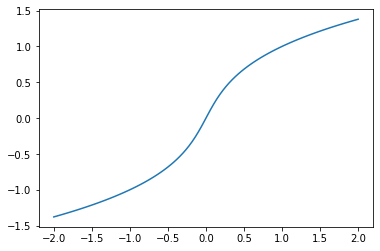

In [9]:
x = np.linspace(-2,2,100)
plt.plot(x, np.vectorize(lambda t_: extract_real_solution(t_, 1, 1))(x))

In [10]:
def simpler(tt, level = 0):
    if level == 0:
        testme = tt.simplify()
        ops0 = testme.count_ops()
        tested = simpler(testme, 1)
        ops1= tested.count_ops()
        if ops1 < ops0:
            return tested
        else:
            return testme
    else:
        if tt.is_Add:
            coeffs = dict()

            for pp in tt.args:
                for qq in pp.args:
                    if qq in coeffs.keys():
                        coeffs[qq] = coeffs[qq] + 1 
                    else:
                        coeffs[qq] = 1

            if len(coeffs) > 2:
                for pp in np.argsort(coeffs.values())[::-1]:
              #  print tt
                    tt = tt.collect( list(coeffs.keys())[pp] )
            #    print tt
                tmp = list()
                for pp in tt.args:
                    tmp.append(simpler(pp, 1))
                return Add(*tmp)
            else:
                return tt
        elif len(tt.args) > 1:  
            tmp = list()
            for pp in tt.args:
                tmp.append(simpler(pp.expand(), 1))
            return tt.func(*tmp)
        else:
            return tt 

def block_simpler(symbols, exprs, tprefix = 'const real_t '):
    opers0 = 0
    for ee in exprs:
        opers0 = opers0 +  ee.count_ops() + 1
    
    print ("// Opers0 = ", opers0   )
    
    temp = cse(exprs,optimizations='basic')
    opers = 0
    for nn,ee in temp[0]:
        ee = simpler(ee)
        opers = opers +  ee.count_ops() + 1
        print (tprefix, ccode(nn),'=',ccode(ee), '; //', ee.count_ops())

    for nn,ee in zip( symbols, temp[1] ):
        ee = simpler(ee)
        opers = opers + ee.count_ops() + 1
        print (ccode(nn),'=',ccode(ee), '; //', ee.count_ops())

    print ("// Opers = ", opers )
    

 

In [31]:
for inp, dum in zip(inputs, dummies):
    print("// %s = %s"%(dum, inp))
    
block_simpler([phi], [symbolic_solutions_as_matrix.subs(dict(zip(inputs, dummies)))[2]])

// tmp[0] = \tilde{\phi}
// tmp[1] = \lambda
// tmp[2] = \delta{t}
// Opers0 =  56
const real_t  x0 = cbrt(3) ; // 2
const real_t  x1 = 1/(tmp[1]*tmp[2]) ; // 2
const real_t  x2 = tmp[1]*tmp[2] ; // 1
const real_t  x3 = cbrt(-9*tmp[0]*x1 + sqrt(3)*sqrt((27*pow(tmp[0], 2) + x1*pow(2 - x2, 3))/(pow(tmp[1], 2)*pow(tmp[2], 2)))) ; // 20
\phi = -1.0/3.0*x0*(x0*x1*(x2 - 2) + pow(x3, 2))/x3 ; // 9
// Opers =  39


In [12]:
Q 

⎡             ⎛        2⎞⎤
⎣\lambda⋅\phi⋅⎝1 - \phi ⎠⎦

In [ ]:
inputs = [tilde_phi, Lam, DT]
dummies = symbols("tmp[0:%d]"%len(inputs))
# dummies = symbols(["tilde_phi", "Lam", "DT"])
# inputs.append(phi)
# dummies.append(symbols("phiii"))
Q[0].subs(dict(zip(inputs, dummies)))


In [ ]:
dummies, inputs

In [ ]:
Qsymbol = symbols('Q', real=True)
print(f'const real_t {Qsymbol};')
block_simpler([Qsymbol], [Q[0].subs(dict(zip(inputs, dummies)))])

            ⎛        2⎞
\phi⋅tmp[1]⋅⎝1 - \phi ⎠

In [14]:
dummies, inputs

([tildeᵩ, Lam, DT, phiii], [\tilde{\phi}, \lambda, \delta{t}, \phi])

In [30]:
Qsymbol = symbols('Q', real=True)
print(f'const real_t {Qsymbol};')
block_simpler([Qsymbol], [Q[0].subs(dict(zip(inputs, dummies)))])

const real_t Q;
// Opers0 =  5
Q = \phi*tmp[1]*(1 - pow(\phi, 2)) ; // 4
// Opers =  5
